In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Nov 26 21:30:19 2021

@author: ruksanakhan
"""

'\nCreated on Fri Nov 26 21:30:19 2021\n\n@author: ruksanakhan\n'

In [2]:
!pip install pyts
!pip install pyclustering
!pip install umap-learn
!pip install fuzzy-c-means

In [3]:
import pandas as pd
import numpy as np
import re

import math 
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE
import umap.umap_ as umap


from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

import seaborn as sns
sns.set()

from sklearn.cluster import Birch

from fcmeans import FCM



#Define all the functions

In [4]:
#Define function to plot 
def plot_with_center(X, Y, label, dim_reduc, cluster_method, centers): 
    plt.scatter(X, Y, c=label, cmap='rainbow', alpha = 0.6, s=10)
    plt.scatter(centers[:, 0], centers[:, 1], c='black', marker="+", s=100, alpha=0.5)    
    plt.title(dim_reduc + "_" +cluster_method)
    plt.xlabel("X")
    plt.ylabel("Y")

 #   plt.savefig(dim_reduc + cluster_method + ".png")
    return plt.show()

def plot(X, Y, label, dim_reduc, cluster_method): 
    plt.scatter(X, Y, c=label, cmap='rainbow', alpha = 0.6, s=10)
    plt.title(dim_reduc +cluster_method)
    plt.xlabel("X")
    plt.ylabel("Y")

   # plt.savefig(dim_reduc + cluster_method + ".png")
    return plt.show()

#Define PAA function
def paa(X, window_size):
    paa = PiecewiseAggregateApproximation(window_size=window_size, overlapping=True)
    X_paa = paa.transform(X)   
    return X_paa

#Define standard scaler
def standard_scalar(X):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(X)
    return scaled_features

#Define PCA function  
def pca(X, components):
    ipca = IncrementalPCA(n_components= components)
    ipca.fit(X)
    return ipca.transform(X)

#Find k from elbow method with WSS
def Elbow_Method(X, k, dim_red):
  sse = []
  for k in range(1, k+1):
      kmeans_ = kmeans(X, k)
      centroids = kmeans_.cluster_centers_
      pred_clusters = kmeans_.predict(X)
      curr_sse = 0
      
      for i in range(len(X)):
        curr_center = centroids[pred_clusters[i]]
        curr_sse += (X[i, 0] - curr_center[0]) ** 2 + (X[i, 1] - curr_center[1]) ** 2
      sse.append(curr_sse)

  k = [i for i in range(1, k+1)]

  plt.figure()
  sns.lineplot(x=k, y=sse)
  plt.title(dim_red + "WSS vs K")
  plt.xlabel('Number of clusters K')
  plt.ylabel("Total within-clusters sum of squares")
  plt.savefig(dim_red + "K means WSS")

#Partition - Kmeans clustering 
def kmeans(X, n_cluster):   
    kmeans = KMeans(n_clusters   =  n_cluster)  
    return kmeans.fit(X)

#Density based - dbscan
def dbscan(X, eps, min_sample):
    clustering = DBSCAN(eps=eps, min_samples=min_sample).fit(X)   
    return clustering

#Hierarchical - BIRCH
def birch(X, branch_fact, n_clusters, threshold):
    #Following runs the BIRCH algorithm
    brc = Birch(branching_factor = branch_fact, n_clusters = n_clusters, threshold = threshold) 
    return brc.fit(X)

#soft clustering - Fuzzy C-Mean
def fcm(X, clusters):
  fcm = FCM(n_clusters= clusters)
  return fcm.fit(X)



Load the data

In [5]:
df = pd.read_csv("1. pose-output.csv")

In [6]:
df.head(5)

,name,xX_left_shoulder,yY_left_shoulder,zZ_left_shoulder,xX_right_shoulder,yY_right_shoulder,zZ_right_shoulder,xX_left_elbow,yY_left_elbow,zZ_left_elbow,xX_right_elbow,yY_right_elbow,zZ_right_elbow,xX_left_wrist,yY_left_wrist,zZ_left_wrist,xX_right_wrist,yY_right_wrist,zZ_right_wrist,xX_left_hip,yY_left_hip,zZ_left_hip,xX_right_hip,yY_right_hip,zZ_right_hip,xX_left_knee,yY_left_knee,zZ_left_knee,xX_right_knee,yY_right_knee,zZ_right_knee,xX_left_ankle,yY_left_ankle,zZ_left_ankle,xX_right_ankle,yY_right_ankle,zZ_right_ankle,left_shoulder__left_wrist,right_wrist__left_wrist,left_elbow__left_wrist,right_elbow__right_wrist,left_hip__left_ankle,right_hip__right_ankle,right_wrist__right_shoulder,right_knee__left_knee,right_ankle__left_ankle,right_wrist__right_ankle,left_wrist__left_ankle,right_wrist__right_knee,left_wrist__left_knee
0,Seated Jackknife,"[0.5418540835380554, 0.5442179441452026, 0.542...","[0.3002445101737976, 0.2985352575778961, 0.301...","[-0.012251616455614567, -0.014628192409873009,...","[0.5088052749633789, 0.5077652931213379, 0.508...","[0.3219769299030304, 0.3233363628387451, 0.320...","[-0.29006227850914, -0.3067556917667389, -0.29...","[0.5200956463813782, 0.5252318978309631, 0.518...","[0.43313315510749817, 0.43440017104148865, 0.4...","[0.023481255397200584, 0.027144629508256912, 0...","[0.48235487937927246, 0.4836348593235016, 0.48...","[0.4504028856754303, 0.4530404508113861, 0.452...","[-0.34773996472358704, -0.36112168431282043, -...","[0.5298163294792175, 0.5288264155387878, 0.522...","[0.5152466893196106, 0.5188010334968567, 0.516...","[-0.053506262600421906, -0.05365733057260513, ...","[0.4858378767967224, 0.48709478974342346, 0.48...","[0.5662975907325745, 0.567011833190918, 0.5698...","[-0.37318840622901917, -0.3764094412326813, -0...","[0.5519704818725586, 0.5512886643409729, 0.552...","[0.5113722085952759, 0.5112325549125671, 0.512...","[0.09740140289068222, 0.10304047912359238, 0.0...","[0.5347285866737366, 0.5333852767944336, 0.534...","[0.544847309589386, 0.5438390970230103, 0.5467...","[-0.0975169762969017, -0.10314539819955826, -0...","[0.6598052382469177, 0.6585541367530823, 0.660...","[0.48735326528549194, 0.48823118209838867, 0.4...","[0.07413876801729202, 0.07978099584579468, 0.0...","[0.6464101076126099, 0.6456512808799744, 0.646...","[0.525979220867157, 0.5270844101905823, 0.5269...","[-0.1422564834356308, -0.1523975282907486, -0....","[0.6857618689537048, 0.6853931546211243, 0.685...","[0.6739863157272339, 0.6749678254127502, 0.674...","[0.19033436477184296, 0.20084527134895325, 0.1...","[0.6738548278808594, 0.6742415428161621, 0.673...","[0.7142422795295715, 0.7170389890670776, 0.714...","[-0.026912769302725792, -0.030070703476667404,...","[0.21925508064526714, 0.22422574522063576, 0.2...","[0.3267062469411898, 0.328990478181663, 0.3284...","[0.11297876839533445, 0.11689902862586603, 0.1...","[0.11870693790317313, 0.11504417686981344, 0.1...","[0.23017388752729162, 0.23315023161325266, 0.2...","[0.23029485638792568, 0.2349012585971055, 0.23...","[0.25909465412553867, 0.25427671811613684, 0.2...","[0.2202232930928984, 0.23576031068245906, 0.22...","[0.22126598815086604, 0.2349819752379838, 0.22...","[0.4208857583322643, 0.4212868096159516, 0.419...","[0.3301144223315916, 0.33715394861846365, 0.33...","[0.28414532412631166, 0.27733679368033176, 0.2...","[0.18430521790866844, 0.18859900430098123, 0.1..."
1,hanging leg raises_4,"[0.5782945156097412, 0.5766435265541077, 0.578...","[0.26492059230804443, 0.26829394698143005, 0.2...","[0.23363590240478516, 0.2346416413784027, 0.17...","[0.3990108072757721, 0.39986276626586914, 0.39...","[0.2629733383655548, 0.2652568817138672, 0.267...","[0.18077099323272705, 0.21373336017131805, 0.1...","[0.5760862231254578, 0.5784265398979187, 0.580...","[0.1357021927833557, 0.139947772026062, 0.1494...","[0.12392085790634155, 0.08857688307762146, -0....","[0.40018072724342346, 0.39951637387275696, 0.4...","[0.13350796699523926, 0.13342714309692383, 0.1...",

In [7]:
type(df["xX_left_shoulder"][0])

str

Element in every column is a string so convert it into timeseries data (Covert the string data into list of list of float values)

In [8]:
columns = df.columns.tolist()[1:]
for i in columns:
    # print(i)
    split_str = [re.split(', |, |/[ |]', x.strip("[]")) for x in df[i].tolist()]

    convert= [[float(t) for t in l] for l in split_str]

    df[i]  = convert

In [9]:
df.columns

Index(['name', 'xX_left_shoulder', 'yY_left_shoulder', 'zZ_left_shoulder',
       'xX_right_shoulder', 'yY_right_shoulder', 'zZ_right_shoulder',
       'xX_left_elbow', 'yY_left_elbow', 'zZ_left_elbow', 'xX_right_elbow',
       'yY_right_elbow', 'zZ_right_elbow', 'xX_left_wrist', 'yY_left_wrist',
       'zZ_left_wrist', 'xX_right_wrist', 'yY_right_wrist', 'zZ_right_wrist',
       'xX_left_hip', 'yY_left_hip', 'zZ_left_hip', 'xX_right_hip',
       'yY_right_hip', 'zZ_right_hip', 'xX_left_knee', 'yY_left_knee',
       'zZ_left_knee', 'xX_right_knee', 'yY_right_knee', 'zZ_right_knee',
       'xX_left_ankle', 'yY_left_ankle', 'zZ_left_ankle', 'xX_right_ankle',
       'yY_right_ankle', 'zZ_right_ankle', 'left_shoulder__left_wrist',
       'right_wrist__left_wrist', 'left_elbow__left_wrist',
       'right_elbow__right_wrist', 'left_hip__left_ankle',
       'right_hip__right_ankle', 'right_wrist__right_shoulder',
       'right_knee__left_knee', 'right_ankle__left_ankle',
       'right_wrist__

In [10]:
# Remove the columns which are not necessary
df_1 = df.drop(columns = df.columns.tolist()[37:])
df_1.columns


Index(['name', 'xX_left_shoulder', 'yY_left_shoulder', 'zZ_left_shoulder',
       'xX_right_shoulder', 'yY_right_shoulder', 'zZ_right_shoulder',
       'xX_left_elbow', 'yY_left_elbow', 'zZ_left_elbow', 'xX_right_elbow',
       'yY_right_elbow', 'zZ_right_elbow', 'xX_left_wrist', 'yY_left_wrist',
       'zZ_left_wrist', 'xX_right_wrist', 'yY_right_wrist', 'zZ_right_wrist',
       'xX_left_hip', 'yY_left_hip', 'zZ_left_hip', 'xX_right_hip',
       'yY_right_hip', 'zZ_right_hip', 'xX_left_knee', 'yY_left_knee',
       'zZ_left_knee', 'xX_right_knee', 'yY_right_knee', 'zZ_right_knee',
       'xX_left_ankle', 'yY_left_ankle', 'zZ_left_ankle', 'xX_right_ankle',
       'yY_right_ankle', 'zZ_right_ankle'],
      dtype='object')

In [11]:
print("First exercise = ", df_1["name"][0], ", time series length  =", len(df_1['xX_left_shoulder'][0]))
print("second exercide = ", df_1["name"][1], ", time series length =", len(df_1['yY_left_shoulder'][1]))

First exercise =  Seated Jackknife , time series length  = 120
second exercide =  hanging leg raises_4 , time series length = 1144


Since the time series data is not of equal length, to make it of same length I used PAA

In [12]:
#get the length of time series data
time_series_length = [len(df_1.iloc[i, 1]) for i in range(len(df_1))]

#To make the length of the time series equal
for j in range(len(df_1)):  
 
    Exercise = df_1[df_1["name"] == df_1["name"][j]].drop(columns = ["name"]).T 
    Exercise.columns = ["Time_series"]
    
    X = np.array(Exercise["Time_series"].tolist())

#5.9 was the factor to get the time series length as 6   
    X_paa = paa(X, math.ceil(time_series_length[j]/5.9))
  
    Exercise_df = pd.DataFrame(X_paa).T
    Exercise_df.columns = df_1.columns.tolist()[1:]

       
    for i in range(len(df_1.columns.tolist()[1:])):
        # print(i)
        df_1.iloc[j][i+1] = list(Exercise_df.iloc[:, i])


In [13]:
#Now that I have applied PAA the time series length of all exercise should be 6
print("First exercise = ", df_1["name"][0], ", time series length  =", len(df_1['xX_left_shoulder'][0]))
print("second exercide = ", df_1["name"][1], ", time series length =", len(df_1['yY_left_shoulder'][1]))

First exercise =  Seated Jackknife , time series length  = 6
second exercide =  hanging leg raises_4 , time series length = 6


In [14]:
#Convert the data into 1D
Flatten_list = []
for i in range(1, len(df_1)):
    Flatten_list.append(list(np.concatenate(df_1.iloc[i][1:35].tolist()).flat))
    
X = np.asarray(Flatten_list)

#PCA

In [15]:
PCA_result = pca(X, 2)

# Convert PCA output into dataframe
PCA_out = pd.DataFrame(PCA_result)  
PCA_out.columns = ["X", "Y"] 
PCA_out["name"] = df_1["name"]

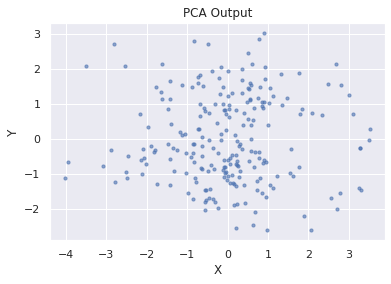

In [16]:
#Scale the PCA output the data and plot
scaled_pca = standard_scalar(PCA_result)

#Plot the PCA output
plt.scatter(PCA_out.X, PCA_out.Y, cmap='rainbow', alpha = 0.6, s=10)
plt.title("PCA Output")
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig("PCA_Scatter_plot")


###PCA and Kmeans

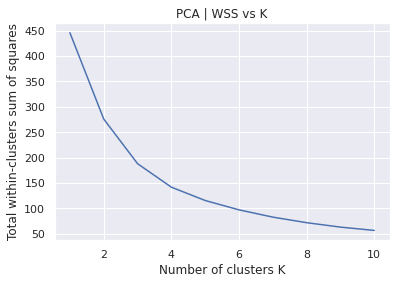

In [17]:

Elbow_Method(scaled_pca, 10, "PCA | ")

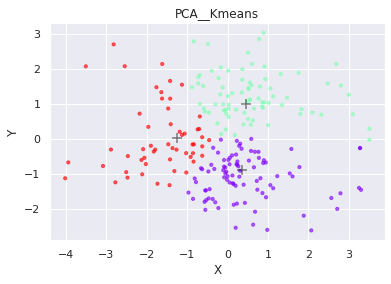

In [18]:
#from the graph take the k
kmeans_ = kmeans(scaled_pca, 3)
centers = kmeans_.cluster_centers_

PCA_out["label_pca_kmeans"] = kmeans_.labels_.tolist()
PCA_out.to_csv("PCA_out_output.csv")

plot_with_center(PCA_out.X, PCA_out.Y, PCA_out.label_pca_kmeans, "PCA_", "Kmeans", centers)

### PCA and DBSCAN

In [19]:
#find the best eps using silhouette_score
eps = [ .09, .1, .2, .3, .4, .5, .6, .7]

for i in eps:
    dbs = dbscan(scaled_pca, i, 5)
    label = dbs.labels_
    
    silhoutte_s = silhouette_score(scaled_pca, label)
    
    print("for eps =", i,
          "silhouette_score is =", silhoutte_s)
    

for eps = 0.09 silhouette_score is = -0.23161663651298053
for eps = 0.1 silhouette_score is = -0.1832470791881145
for eps = 0.2 silhouette_score is = -0.14913461757759575
for eps = 0.3 silhouette_score is = 0.02574443581159348
for eps = 0.4 silhouette_score is = 0.2884029398912686
for eps = 0.5 silhouette_score is = 0.28700819402735284
for eps = 0.6 silhouette_score is = 0.24434833019806118
for eps = 0.7 silhouette_score is = 0.26405304836332955


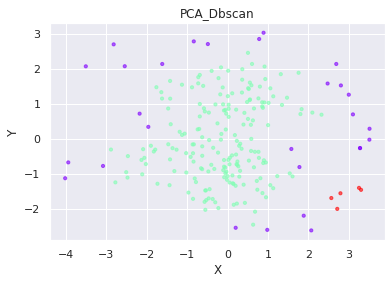

In [20]:
dbs = dbscan(scaled_pca, .4, 5)
PCA_out["label_pca_DBscan"] = dbs.labels_
plot(PCA_out.X, PCA_out.Y, PCA_out.label_pca_DBscan, "PCA_", "Dbscan")


### PCA and Birch

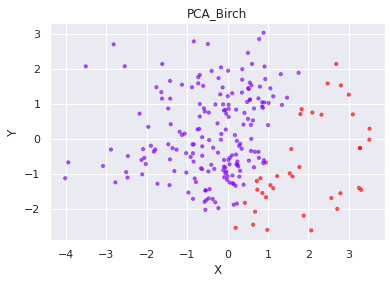

In [21]:
# Hierarchical cluster - Birch

birch_ = birch(scaled_pca, 50, None, 1.5)
PCA_out["label_pca_Birch"] = birch_.predict(scaled_pca)

plot(PCA_out.X, PCA_out.Y, PCA_out.label_pca_Birch, "PCA_", "Birch")


### PCA and Fuzzy C-means

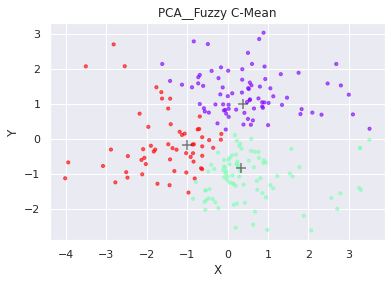

In [22]:
#soft clustering - Fuzzy C-means
fcm = FCM(n_clusters=3)
fcm.fit(scaled_pca)
# Get the center and label
fcm_centers = fcm.centers
PCA_out["label_pca_fcm"] = fcm.predict(scaled_pca)

plot_with_center(PCA_out.X, PCA_out.Y, PCA_out.label_pca_fcm, "PCA_", "Fuzzy C-Mean", fcm_centers)



In [23]:
PCA_out.to_csv("PCA_output.csv")

In [24]:
PCA_out.head(5)

,X,Y,name,label_pca_kmeans,label_pca_DBscan,label_pca_Birch,label_pca_fcm
0,0.240622,-0.740892,Seated Jackknife,0,0,0,1
1,0.116600,1.302051,hanging leg raises_4,1,0,0,0
2,-0.699350,0.283705,lat pull-downs (3),2,0,0,2
3,0.525578,1.424944,The Deadlift,1,0,0,0
4,0.945954,-0.674615,seated rows (4),0,0,1,1


#tSNE

In [25]:
#tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
#tsne_results = tsne.fit_transform(X)

#scale the data and plot
#scaled_tSNE = standard_scalar(tsne_results)

#tsne_out = pd.DataFrame(scaled_tSNE)  
#tsne_out.columns = ["X", "Y"] 
#tsne_out["name"] = df_1["name"]


In [26]:
tSNE_out = pd.read_csv("tSNE_output.csv")
tsne_out = tSNE_out.drop(columns = ["label_tsne_kmeans", "label_tsne_DBscan", "labels_tSNE_birch", "label_tsne_fcm"])



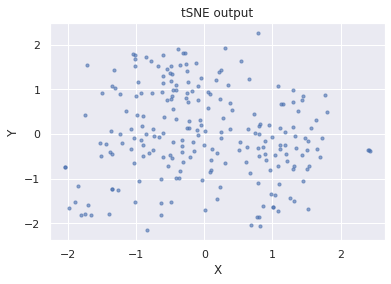

In [27]:
#Plot tSNE out
plt.scatter(tsne_out.X, tsne_out.Y, cmap='rainbow', alpha = 0.6, s=10)
plt.title("tSNE output")
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig("tSNE Scatter plot")


In [28]:
#Convert data into numpy array
scaled_tSNE = np.array(tsne_out[["X", "Y"]])

### tSNE and k-means

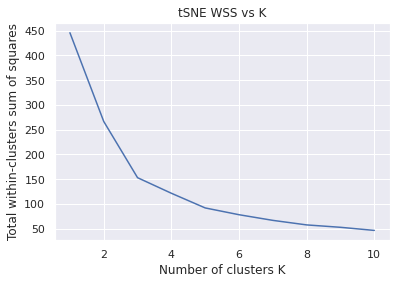

In [29]:
#Get the optimal value of k from elbow WSS method
Elbow_Method(scaled_tSNE, 10, "tSNE ")

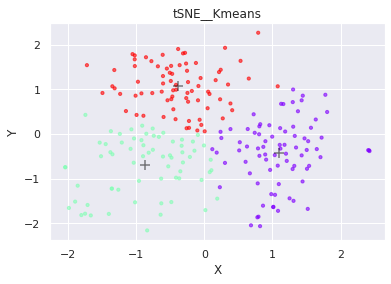

In [30]:
#Kmeans
tsne_kmeans = kmeans(scaled_tSNE, 3)
tsne_out["label_tsne_kmeans"] = tsne_kmeans.labels_.tolist()
centers = tsne_kmeans.cluster_centers_

plot_with_center(tsne_out.X, tsne_out.Y, tsne_out.label_tsne_kmeans, "tSNE_", "Kmeans", centers)


### tSNE and DBSCAN 

In [31]:
eps = [.2, .3, .4,.5, .55, .56, .57, .6]
for i in eps:
    dbs = dbscan(scaled_tSNE, i, 5)
    label = dbs.labels_
    
    silhoutte_s = silhouette_score(scaled_tSNE, label)
    
    print("for eps =", i,
          "silhouette_score is =", silhoutte_s)
    


for eps = 0.2 silhouette_score is = -0.23306279763245924
for eps = 0.3 silhouette_score is = -0.10788382315923328
for eps = 0.4 silhouette_score is = 0.16490390690886592
for eps = 0.5 silhouette_score is = 0.2642605844383859
for eps = 0.55 silhouette_score is = 0.28870710970992
for eps = 0.56 silhouette_score is = 0.28870710970992
for eps = 0.57 silhouette_score is = 0.28870710970992
for eps = 0.6 silhouette_score is = 0.26461875923797734


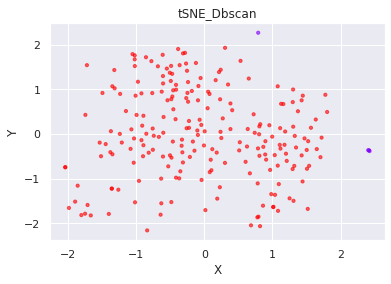

In [32]:
dbs = dbscan(scaled_tSNE, .55, 5)
tsne_out["label_tsne_DBscan"] = dbs.labels_
plot(tsne_out.X, tsne_out.Y, tsne_out.label_tsne_DBscan, "tSNE_", "Dbscan")



### tSNE and Birch

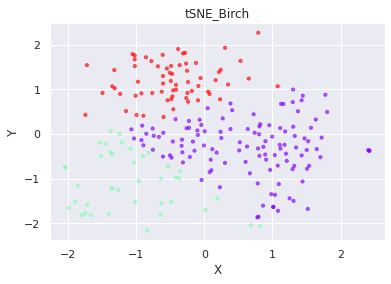

In [33]:
birch_ = birch(scaled_tSNE, 50, None, 1.5)
tsne_out["labels_tSNE_birch"] = birch_.predict(scaled_tSNE)

#Plot
plot(tsne_out.X, tsne_out.Y, tsne_out.labels_tSNE_birch, "tSNE_", "Birch")


### tSNE and Fuzzy C-means

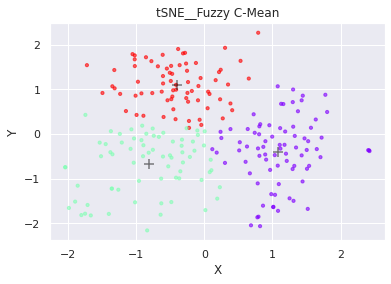

In [34]:
#soft clustering - Fuzzy C-means
fcm = FCM(n_clusters= 3)
fcm.fit(scaled_tSNE)
# Get the center and label
fcm_centers = fcm.centers
tsne_out["label_tsne_fcm"] = fcm.predict(scaled_tSNE)

plot_with_center(tsne_out.X, tsne_out.Y, tsne_out.label_tsne_fcm, "tSNE_", "Fuzzy C-Mean", fcm_centers)



In [35]:
tsne_out.to_csv("tSNE_output.csv")

In [36]:
tsne_out.head(5)

,Unnamed: 0,X,Y,name,label_tsne_kmeans,label_tsne_DBscan,labels_tSNE_birch,label_tsne_fcm
0,0,-0.212060,-0.513821,Seated Jackknife,1,0,0,1
1,1,1.427873,0.756452,hanging leg raises_4,0,0,0,0
2,2,-1.150473,0.515917,lat pull-downs (3),2,0,2,2
3,3,0.782959,-1.107375,The Deadlift,0,0,0,0
4,4,0.231500,0.779592,seated rows (4),2,0,2,2


#UMAP

UMAP is a stochastic algorithm – it makes use of randomness both to speed up approximation steps, and to aid in solving hard optimization problems. This means that different runs of UMAP can produce different results. Hence, I have saved the data to avoid the change in data the after every run

In [37]:
#umap_fit = umap.UMAP(n_components=2)
#umap_result = umap_fit.fit_transform(X)

#standardize the data and plot
#scaled_umap = standard_scalar(umap_result)

# Convert UMAP output into dataframe
#UMAP_out = pd.DataFrame(scaled_umap) 

#UMAP_out.columns = ["X", "Y"] 
#UMAP_out["name"] = df_1["name"]


In [38]:
UMAP_out = pd.read_csv("Umap_out.csv")
UMAP_out = UMAP_out.drop(columns = ["label_umap_kmeans", "label_umap_DBscan", "birch_umap_label", "label_umap_fcm"])

In [39]:
UMAP_out.head(5)

,Unnamed: 0,X,Y,name
0,0,-0.200238,0.396196,Seated Jackknife
1,1,1.766158,-0.564415,hanging leg raises_4
2,2,-1.361212,0.358742,lat pull-downs (3)
3,3,1.829591,-0.769604,The Deadlift
4,4,0.904674,0.929864,seated rows (4)


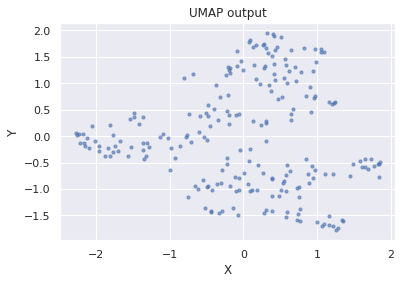

In [40]:
#Plot the data points 
plt.scatter(UMAP_out.X, UMAP_out.Y, cmap='rainbow', alpha = 0.6, s=10)
plt.title("UMAP output")
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig("UMAP Scatter plot")


In [41]:
#Convert data into numpy array
scaled_umap = np.array(UMAP_out[["X", "Y"]])

## UMAP and kMeans

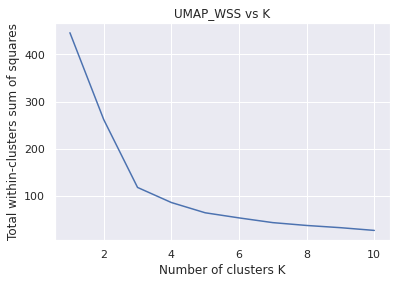

In [42]:
Elbow_Method(scaled_umap, 10, "UMAP_")

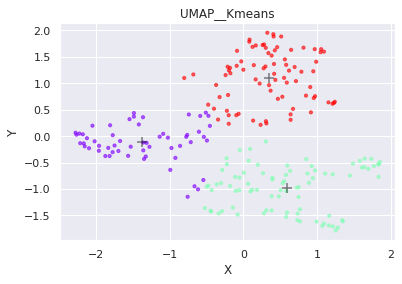

In [43]:
#from the graph take the k
kmeans_= kmeans(scaled_umap, 3)
centers = kmeans_.cluster_centers_

UMAP_out["label_umap_kmeans"] = kmeans_.labels_.tolist()
UMAP_out.to_csv("UMAP_out_output.csv")


plot_with_center(UMAP_out.X, UMAP_out.Y, UMAP_out.label_umap_kmeans, "UMAP_", "Kmeans", centers)


##UMAP and dbscan

In [44]:
eps = [.1, .2, .21, .22, .23, .24, .25, .26, .29, .3, .31]
for i in eps:
    dbs = dbscan(scaled_umap, i, 5)
    label = dbs.labels_
    
    silhoutte_s = silhouette_score(scaled_umap, label)
    
    print("for eps =", i,
          "silhouette_score is =", silhoutte_s)
    

for eps = 0.1 silhouette_score is = -0.05438778903746686
for eps = 0.2 silhouette_score is = 0.21662073428503809
for eps = 0.21 silhouette_score is = 0.2171297803935806
for eps = 0.22 silhouette_score is = 0.28834957732194877
for eps = 0.23 silhouette_score is = 0.2988326044002513
for eps = 0.24 silhouette_score is = 0.07935691749020983
for eps = 0.25 silhouette_score is = 0.15291073700349134
for eps = 0.26 silhouette_score is = 0.1547744164165346
for eps = 0.29 silhouette_score is = 0.16542301810919519
for eps = 0.3 silhouette_score is = -0.02150511184288663
for eps = 0.31 silhouette_score is = -0.02150511184288663


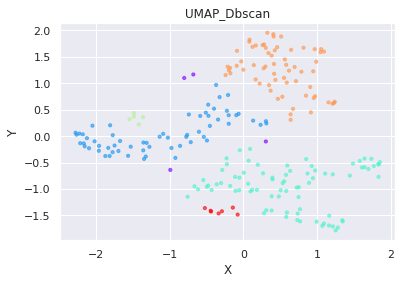

In [45]:
dbs = dbscan(scaled_umap, .29, 5)
UMAP_out["label_umap_DBscan"] = dbs.labels_
plot(UMAP_out.X, UMAP_out.Y, UMAP_out.label_umap_DBscan, "UMAP_", "Dbscan")


##UMAP Birch

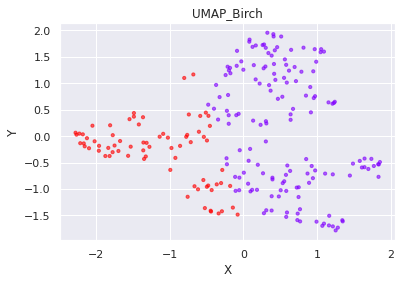

In [46]:
# Hierarchical cluster - Birch
umap_birch = birch(scaled_umap, 50, None, 1.5)
UMAP_out["label_umap_birch"] = umap_birch.predict(scaled_umap)

plot(UMAP_out.X, UMAP_out.Y, UMAP_out.label_umap_birch, "UMAP_", "Birch")


### UMAP and fcm

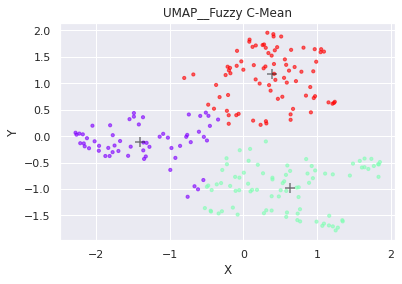

In [47]:
#soft clustering - Fuzzy C-means
fcm = FCM(n_clusters=3)
fcm.fit(scaled_umap)
# Get the center and label
fcm_centers = fcm.centers
UMAP_out["label_umap_fcm"] = fcm.predict(scaled_umap)

plot_with_center(UMAP_out.X, UMAP_out.Y, UMAP_out.label_umap_fcm, "UMAP_", "Fuzzy C-Mean", fcm_centers)



In [48]:
UMAP_out.head(5)

,Unnamed: 0,X,Y,name,label_umap_kmeans,label_umap_DBscan,label_umap_birch,label_umap_fcm
0,0,-0.200238,0.396196,Seated Jackknife,2,0,0,2
1,1,1.766158,-0.564415,hanging leg raises_4,1,1,0,1
2,2,-1.361212,0.358742,lat pull-downs (3),0,2,1,0
3,3,1.829591,-0.769604,The Deadlift,1,1,0,1
4,4,0.904674,0.929864,seated rows (4),2,3,0,2


In [49]:
#UMAP_out.to_csv("Umap_out.csv")

In [50]:
#Save the data with all the labels
UMAP_out.to_csv("UMAP_output.csv")

In [51]:
#Merge all outputs
PCA_tSNE = PCA_out.merge(tsne_out, how= "left", on = "name")
PCA_tSNE_umap = PCA_tSNE.merge(UMAP_out, how= "left", on = "name")
PCA_tSNE_umap.to_csv("PCA_tSNE_umap.csv")

In [52]:
PCA_tSNE_umap.head(5)

,X_x,Y_x,name,label_pca_kmeans,label_pca_DBscan,label_pca_Birch,label_pca_fcm,Unnamed: 0_x,X_y,Y_y,label_tsne_kmeans,label_tsne_DBscan,labels_tSNE_birch,label_tsne_fcm,Unnamed: 0_y,X,Y,label_umap_kmeans,label_umap_DBscan,label_umap_birch,label_umap_fcm
0,0.240622,-0.740892,Seated Jackknife,0,0,0,1,0,-0.212060,-0.513821,1,0,0,1,0,-0.200238,0.396196,2,0,0,2
1,0.116600,1.302051,hanging leg raises_4,1,0,0,0,1,1.427873,0.756452,0,0,0,0,1,1.766158,-0.564415,1,1,0,1
2,-0.699350,0.283705,lat pull-downs (3),2,0,0,2,2,-1.150473,0.515917,2,0,2,2,2,-1.361212,0.358742,0,2,1,0
3,0.525578,1.424944,The Deadlift,1,0,0,0,3,0.782959,-1.107375,0,0,0,0,3,1.829591,-0.769604,1,1,0,1
4,0.945954,-0.674615,seated rows (4),0,0,1,1,4,0.231500,0.779592,2,0,2,2,4,0.904674,0.929864,2,3,0,2
